In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

data = np.load("../data/jupiter_frames_uint8.npz")
arr = data["frames"]

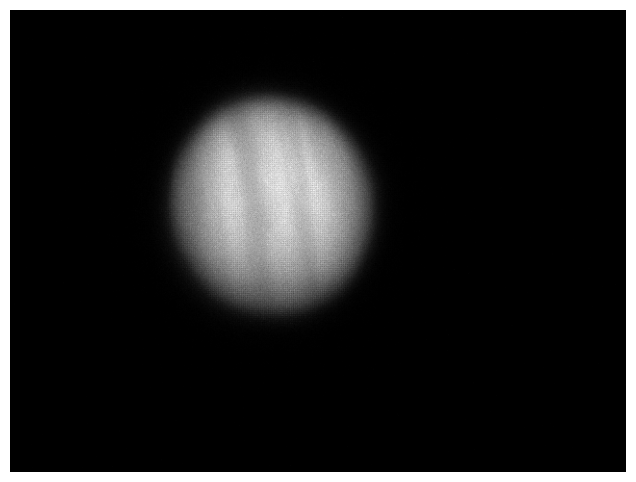

In [3]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fps = float(data["fps"])

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(arr[0], cmap="gray")
ax.axis("off")


def animate(i):
    im.set_data(arr[i])
    return [im]


ani = animation.FuncAnimation(fig, animate, frames=60,
                              interval=1000.0 / max(fps, 1), blit=True)
HTML(ani.to_jshtml())

(-0.5, 639.5, 479.5, -0.5)

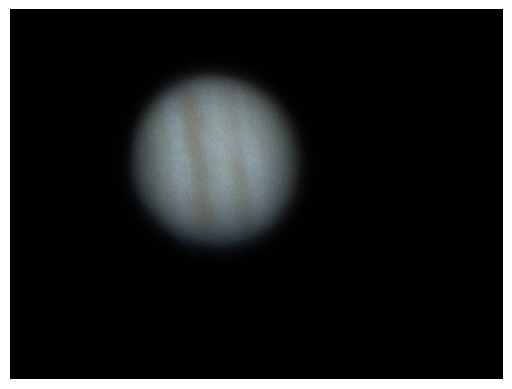

In [4]:
from src.debayer import debayer_stack

pattern = "RGGB"
method = "VNG"  # or "BILINEAR" or "EA"

deb_frames = debayer_stack(arr, pattern=pattern, method=method)
plt.imshow(deb_frames[0])
plt.axis("off")

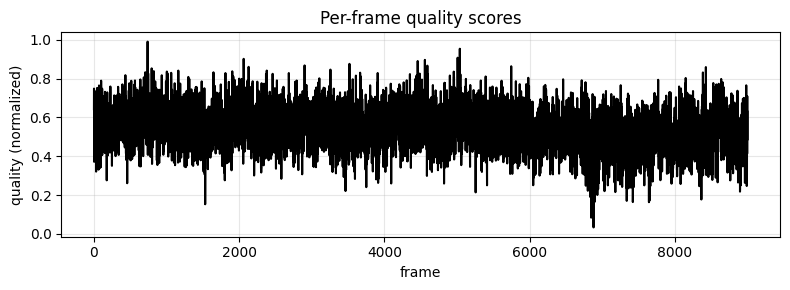

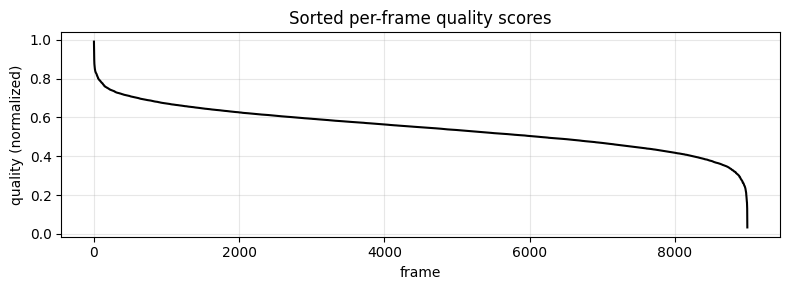

In [5]:
from src.quality_and_align import compute_quality_scores

# scores, _, _ = compute_quality_scores(deb_frames)
scores = np.load("../data/scores.npz")["arr_0"]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(scores, '-k')
ax.set_xlabel('frame')
ax.set_ylabel('quality (normalized)')
ax.set_title('Per-frame quality scores')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(np.sort(scores)[::-1], '-k')
ax.set_xlabel('frame')
ax.set_ylabel('quality (normalized)')
ax.set_title('Sorted per-frame quality scores')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

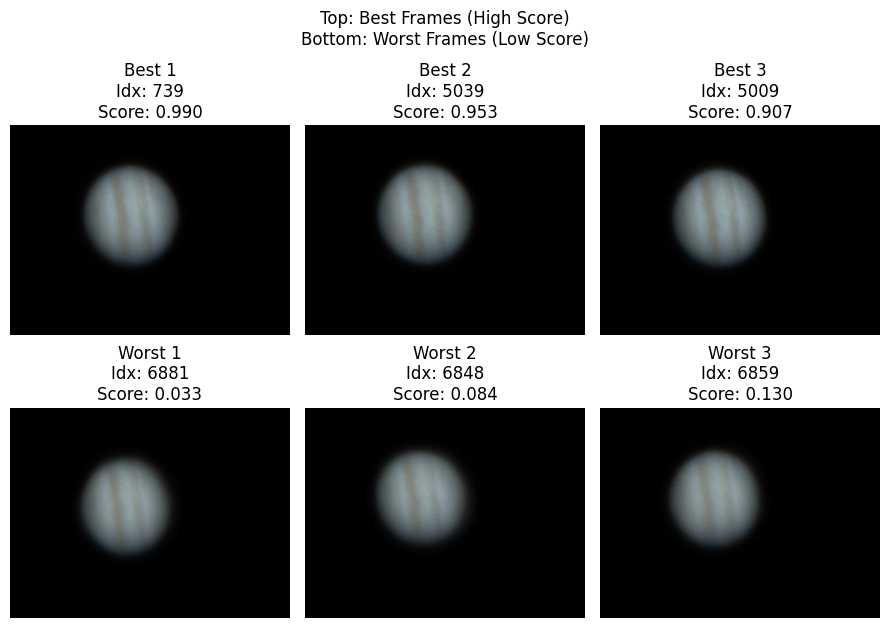

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Number of frames to visualize from each end
N = 3

# Sort indices by score
sorted_indices = np.argsort(scores)

# Get best and worst indices
worst_indices = sorted_indices[:N]
best_indices = sorted_indices[-N:][::-1]  # reverse for descending

fig, axs = plt.subplots(2, N, figsize=(3 * N, 6.75))

for i in range(N):
    idx = best_indices[i]
    axs[0, i].imshow(deb_frames[idx])
    axs[0, i].set_title(f"Best {i + 1}\nIdx: {idx}\nScore: {scores[idx]:.3f}")
    axs[0, i].axis('off')

    idx = worst_indices[i]
    axs[1, i].imshow(deb_frames[idx])
    axs[1, i].set_title(f"Worst {i + 1}\nIdx: {idx}\nScore: {scores[idx]:.3f}")
    axs[1, i].axis('off')

plt.suptitle("Top: Best Frames (High Score)\nBottom: Worst Frames (Low Score)")
plt.tight_layout()
plt.show()

In [7]:
from src.quality_and_align import choose_reference_frame

reference_idx = choose_reference_frame(scores)
reference_frame = deb_frames[reference_idx]

In [8]:
from src.quality_and_align import detect_ref_points

n_ref_points = 100
ref_pts = detect_ref_points(reference_frame, max_corners=n_ref_points)

In [9]:
print(ref_pts.__len__())

100


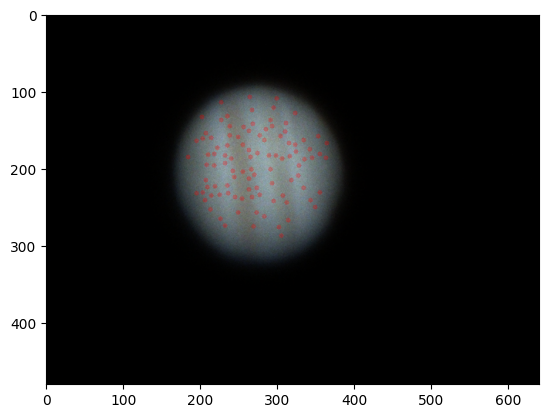

In [10]:
from src.visualize_results import overlay_points

image = overlay_points(reference_frame, ref_pts, (1, 0, 0), alpha=0.3)
plt.imshow(image)
plt.show()

In [11]:
from src.quality_and_align import align_frames

idx_to_align = sorted_indices[-100:][::-1]
reference_idx = 0

aligned, transforms = align_frames(deb_frames[idx_to_align], reference_idx, ref_pts)

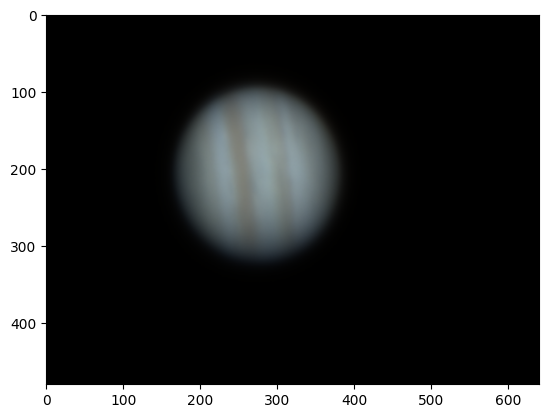

In [12]:
plt.imshow(aligned.sum(0) // len(idx_to_align))
plt.show()

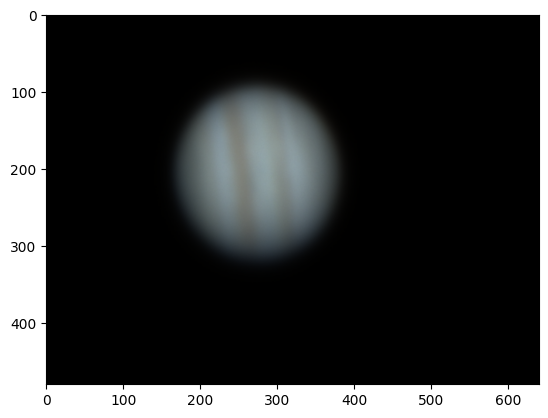

In [13]:
plt.imshow(deb_frames[idx_to_align].sum(0) // len(idx_to_align))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


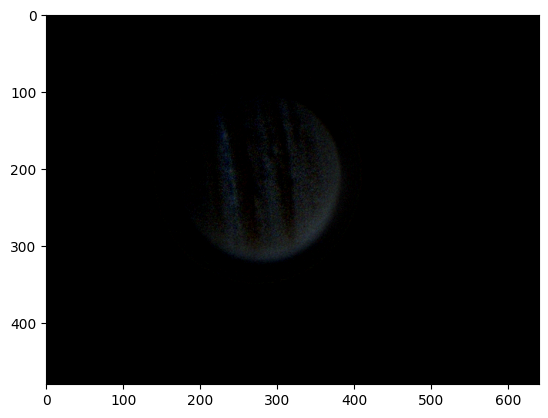

In [14]:
diff = aligned.sum(0).astype(np.int32) // len(idx_to_align) - deb_frames[idx_to_align].sum(0).astype(np.int32) // len(
        idx_to_align)

plt.imshow(diff * 10)
plt.show()

In [15]:
from ipywidgets import interact, FloatSlider, IntSlider
from src.enhance import unsharp_mask_color

img = (aligned.sum(0) // aligned.shape[0]).astype(np.uint8)

result = {'unsharp': None}

def adjust_unsharp(sigma=2.0, amount=1.0, threshold=0):
    out = unsharp_mask_color(img, sigma=sigma, amount=amount, threshold=threshold)
    result['unsharp'] = out
    plt.figure(figsize=(6, 6))
    plt.imshow(out)
    plt.axis('off')
    plt.show()

interact(
    adjust_unsharp,
    sigma=FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1),
    amount=FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1),
    threshold=IntSlider(value=0, min=0, max=10, step=1)
)

interactive(children=(FloatSlider(value=2.0, description='sigma', max=10.0, min=0.1), FloatSlider(value=1.0, d…

<function __main__.adjust_unsharp(sigma=2.0, amount=1.0, threshold=0)>

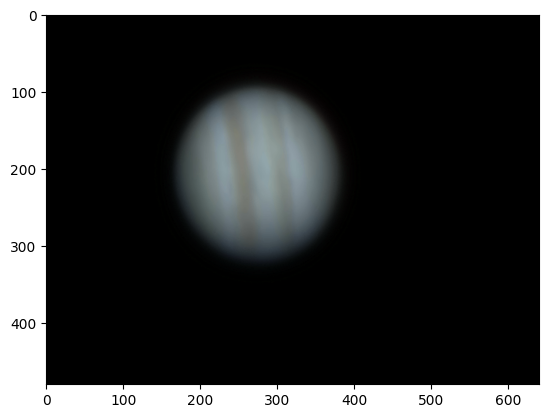

In [16]:
from src.enhance import denoise_color

denoised = denoise_color(result["unsharp"], h=0.5, hColor=0.5)
plt.imshow(denoised)

In [18]:
from src.enhance import adjust_saturation, adjust_contrast_brightness

def adjust_saturation_plot(factor=1.0, contrast=1.0, brightness=1.0):
    out = adjust_saturation(result["unsharp"], factor=factor)
    out = adjust_contrast_brightness(out, contrast=contrast, brightness=brightness)
    result['saturation'] = out
    plt.figure(figsize=(6, 6))
    plt.imshow(out)
    plt.axis('off')
    plt.show()

interact(
    adjust_saturation_plot,
    factor=FloatSlider(value=1.0, min=0.1, max=3.0, step=0.05),
    contrast=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.02),
    brightness=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.02),
)